In [1]:
import json
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

In [4]:
lambd = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80,90, 100]

In [3]:
with open('./results_linear.json') as inp:
    data = json.loads(inp.read())

In [5]:
lambs = [0.01, 0.1, 1, 10, 100] # будем работать только с этими карти

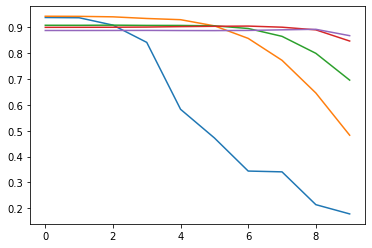

In [6]:
for k in lambs:
    plt.plot(np.mean(data[str(k)], 0))

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# в matplotlib есть функция plot_trisurf, но в ней нет возможности задать отдельный цвет каждой грани
# поэтому слегка модифицируем функцию

In [9]:

from matplotlib import artist
import matplotlib.axes as maxes
import matplotlib.cbook as cbook
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
import matplotlib.docstring as docstring
import matplotlib.projections as proj
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
from matplotlib.axes import Axes, rcParams
from matplotlib.colors import Normalize, LightSource
from matplotlib.transforms import Bbox
from matplotlib.tri.triangulation import Triangulation
from mpl_toolkits.mplot3d import art3d
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import axis3d

def plot_trisurf(self, *args, color=None, norm=None, vmin=None, vmax=None,
                     lightsource=None, **kwargs):
        """
        Plot a triangulated surface.

        The (optional) triangulation can be specified in one of two ways;
        either::

          plot_trisurf(triangulation, ...)

        where triangulation is a :class:`~matplotlib.tri.Triangulation`
        object, or::

          plot_trisurf(X, Y, ...)
          plot_trisurf(X, Y, triangles, ...)
          plot_trisurf(X, Y, triangles=triangles, ...)

        in which case a Triangulation object will be created.  See
        :class:`~matplotlib.tri.Triangulation` for a explanation of
        these possibilities.

        The remaining arguments are::

          plot_trisurf(..., Z)

        where *Z* is the array of values to contour, one per point
        in the triangulation.

        Parameters
        ----------
        X, Y, Z : array-like
            Data values as 1D arrays.
        color
            Color of the surface patches.
        cmap
            A colormap for the surface patches.
        norm : Normalize
            An instance of Normalize to map values to colors.
        vmin, vmax : scalar, optional, default: None
            Minimum and maximum value to map.
        shade : bool
            Whether to shade the facecolors. Defaults to True. Shading is
            always disabled when *cmap* is specified.
        lightsource : `~matplotlib.colors.LightSource`
            The lightsource to use when *shade* is True.
        **kwargs
            All other arguments are passed on to
            :class:`~mpl_toolkits.mplot3d.art3d.Poly3DCollection`

        Examples
        --------

        .. plot:: gallery/mplot3d/trisurf3d.py
        .. plot:: gallery/mplot3d/trisurf3d_2.py

        .. versionadded:: 1.2.0
            This plotting function was added for the v1.2.0 release.
        """

        had_data = self.has_data()

        # TODO: Support custom face colours
        #if color is None:
        #    color = self._get_lines.get_next_color()
        #color = np.array(mcolors.to_rgba(color))

        cmap = kwargs.get('cmap', None)
        shade = kwargs.pop('shade', cmap is None)

        tri, args, kwargs = \
            Triangulation.get_from_args_and_kwargs(*args, **kwargs)
        if 'Z' in kwargs:
            z = np.asarray(kwargs.pop('Z'))
        else:
            z = np.asarray(args[0])
            # We do this so Z doesn't get passed as an arg to PolyCollection
            args = args[1:]

        triangles = tri.get_masked_triangles()
        
        xt = tri.x[triangles]
        yt = tri.y[triangles]
        zt = z[triangles]
        verts = np.stack((xt, yt, zt), axis=-1)
        #print (color)
        polyc = art3d.Poly3DCollection(verts)
        #polyc.set_facecolors(color)
        self.add_collection(polyc)
        self.auto_scale_xyz(tri.x, tri.y, z, had_data)
   
        normals = self._generate_normals(verts)
        #colset = self._shade_colors([1,0,0], normals, lightsource)
        #print (colset.shape)
        colset = []
        for tri in triangles:
            colset.append(np.mean(color[tri], 0))
        
        polyc.set_facecolors(colset)

        

        return polyc

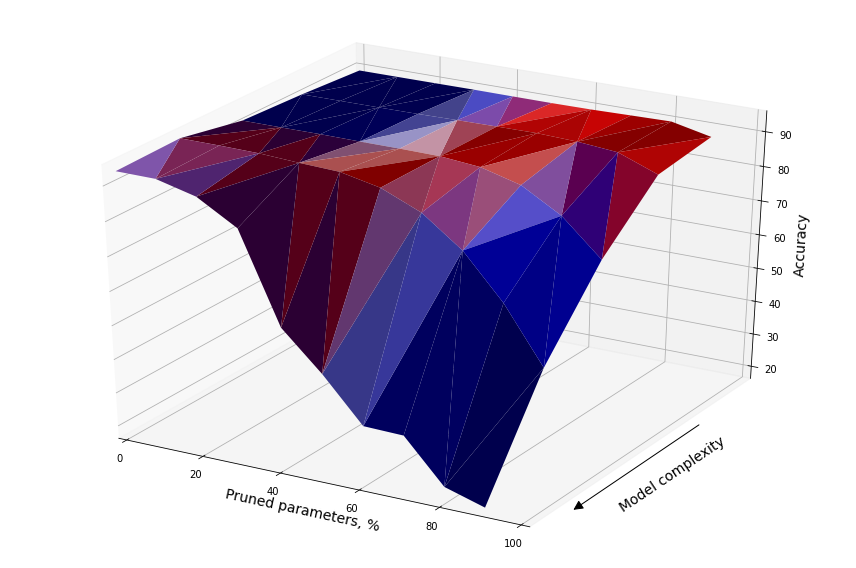

In [11]:
from matplotlib import cm
ax = plt.axes(projection='3d')
x = []
y = []
z = []

for k in lambs:
    x.extend(list(range(0, 100, 10))) # наши проценты удаленных параметров
    y.extend([np.log10(k)]*10) # лямьды в логарифмической шкале
    z.extend(np.mean(data[str(k)], 0) *100) # значения

my_col = [] # цвета для каждой точки
for k in lambs: #lambdas
    for row in range(10): # percentage
        all_values = [np.mean(data[str(k)], 0)[row] for k in lambs]
        max_ = np.max(all_values)
        min_ = np.min(all_values)        
        intesivity = ((np.mean(data[str(k)], 0)[row] - min_)/(max_-min_))**10
        my_col.append(cm.seismic(intesivity)) # перевод в цветовую палитру seismic, от синего к красному
        
my_col = np.array(my_col)    
surf = plot_trisurf(ax, x, y, z, color=my_col, shade=False)
ax.set_xlabel('Pruned parameters, %', fontsize=14)
ax.set_ylabel('Model complexity', fontsize=14)
ax.set_zlabel('Accuracy', fontsize=14)
ax.set_yticks([])

ax.w_yaxis.line.set_visible(False) # убираем ось, отвечающую за сложность
ax.set_xlim(0,100)
ax.set_ylim(-2,2)

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# класс для простого построения стрелок
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

a = Arrow3D([91, 91], [2, -.5], 
                [0,0], mutation_scale=20, 
                lw=1, arrowstyle="-|>", color="k")
ax.add_artist(a)

plt.tight_layout()
plt.rcParams['figure.figsize'] = (12,8)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
